# Notebook Instructions
<i>You can run the notebook document sequentially (one cell at a time) by pressing <b> shift + enter</b>. While a cell is running, a [*] will display on the left. When it has been run, a number will display indicating the order in which it was run in the notebook [8].</i>

<i>Enter edit mode by pressing <b>`Enter`</b> or using the mouse to click on a cell's editor area. Edit mode is indicated by a green cell border and a prompt showing in the editor area.</i>

## Classification Tree

A classification tree automatically selects important predictors and suggests trading rules. In this notebook, we will learn to create a classification tree model. The predictor variables are technical indicators like the Average Directional Index (ADX), Relative Strength Index (RSI), and Simple Moving Average (SMA). The target variable is one-day future return. The classification tree we create will help us build trading rules for when the future return is expected to be positive or negative.

Create a classification tree

 1. Import the data from a csv file 
 2. Create the predictor variables and the target variable
 3. Split the data into train and test dataset
 4. Fit a decision tree model on train data 
 5. Visualize the decision tree model
 6. Make Predictions and evaluate the performance


## Import the data

We will input raw data of a ACC Ltd. stock from a CSV file. Predictor and target variables are created using this raw data. 

In [3]:
import pandas as pd
import numpy as np
import shap
df = pd.read_csv("ACC.csv")
df.tail()

,Date,OPEN,HIGH,LOW,CLOSE
243,6/11/2018,1315.9,1338.8,1311.3,1320.2
244,6/12/2018,1321.0,1329.4,1306.6,1315.7
245,6/13/2018,1317.3,1349.4,1311.6,1331.0
246,6/14/2018,1331.0,1333.3,1304.4,1307.2
247,6/15/2018,1309.7,1314.9,1295.0,1302.1


## Define predictor variables and a target variable

We define a list of predictors using the TA-Lib library for technical indicators from which the model will pick the best predictors.  The predictors used are Average Directional Index (ADX), Relative Strength Index (RSI), and Simple Moving Average (SMA).


In [2]:
# Create the predictors 
import talib as ta 
df['ADX'] = ta.ADX(df['HIGH'].values, df['LOW'].values, df['CLOSE'].values, timeperiod=14)
df['RSI'] = ta.RSI(df['CLOSE'].values, timeperiod=14)
df['SMA'] = ta.SMA(df['CLOSE'].values, timeperiod=20)

df.tail()

ImportError: No module named 'talib'

The target variable is 1-day future returns. 

shift(periods=n) shifts the values by n period(s). If the value of n is negative then, it shifts the values backward and vice-versa.

We will classify the returns in two labels:  0 for negative returns and 1 for positive returns. Next, we drop the NaN values from the dataframe.

In [3]:
df['Return'] = df['CLOSE'].pct_change(1).shift(-1)
df['target'] = np.where(df.Return > 0, 1, 0)

df.tail()

,Date,OPEN,HIGH,LOW,CLOSE,ADX,RSI,SMA,Return,target
243,6/11/2018,1315.9,1338.8,1311.3,1320.2,33.309646,36.468425,1336.025,-0.003409,0
244,6/12/2018,1321.0,1329.4,1306.6,1315.7,32.050041,35.658985,1331.225,0.011629,1
245,6/13/2018,1317.3,1349.4,1311.6,1331.0,30.094175,40.494969,1327.235,-0.017881,0
246,6/14/2018,1331.0,1333.3,1304.4,1307.2,28.520287,35.966371,1322.570,-0.003901,0
247,6/15/2018,1309.7,1314.9,1295.0,1302.1,27.371680,35.061531,1318.955,NaN,0


We drop the NaN values and store the predictor variables in X and target variable in y.

In [4]:
df = df.dropna()

predictors_list = ['ADX','RSI', 'SMA']
X = df[predictors_list]
X.tail()

y = df.target
y.tail()

242    1
243    0
244    1
245    0
246    0
Name: target, dtype: int32

## Split the data into train and test dataset

Before we build a decision tree model, we need to split the data set into train and test data. A decision tree model uses the train data to learn the properties of data and the test data to estimate the model’s accuracy of the predictions.

From sklearn, we use the sub-library called model_selection, and import the train_test_split method. We will use 70% of the data set for training the model and a hold back of 30% for testing. We set the random_state parameter to a fixed number. This ensures that the data is split the same way every time and we get the same model output for each run. 

Another thing to keep in mind during splitting is to ensure that the test data is representative of the train data. This is done using stratify. We assign  stratify = y, so that it splits the data in same proportion as ‘y’. That means if ‘0’s were 45% and ‘1’s 55% in ‘y’, the train and test data will continue to have the same proportion of 45% and 55% of the class labels. 


In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)


(154, 3) (154,)
(66, 3) (66,)


We have training data in the X_train and y_train for creating the regression tree model and a X_test and y_test to verify the model on unseen data.

## Create classification tree model

We have used DecisionTreeClassifier from sklearn.tree to create the classification tree model. We choose to set min_samples_leaf to 400, but you are free to experiment with other values and see what is optimal on the train dataset. 

In [6]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(criterion='gini', max_depth=3, min_samples_leaf=5) 
clf

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

We create the fit() method to train the classifier on the train dataset.

In [7]:
clf = clf.fit(X_train, y_train)

In [8]:
# Uncomment below line to see details of DecisionTreeClassifier
# help(DecisionTreeClassifier)

## Visualize the model

We now visualize the classification tree created in the step below using the graphviz and sklearn's tree package.

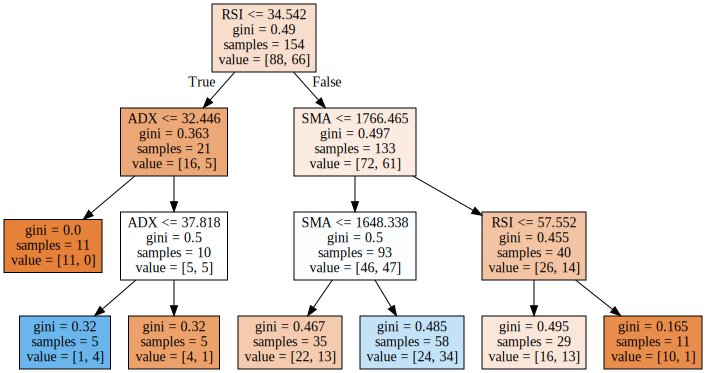

In [9]:
from sklearn import tree
import graphviz
dot_data = tree.export_graphviz(clf, out_file=None,filled=True,feature_names=predictors_list)   
graphviz.Source(dot_data) 

As can be seen in the tree, every node contains some information: 
    
 1. the predictor variable used to split the data set: recall that X[0] is ADI, X[1] is RSI.  
 2. the value of gini impurity, 
 3. the number of data points available at that node and 
 4. the number of target variable data points belonging to each class, 1 and 0.

The left-most path leads to a pure node with 13 data points as ‘1’s, which can be used to define a long rule for a trading strategy. The decision rule can be paraphrased as ADX <= 32.33 and RSI <= 33.258. If during test, this condition is met for a  new data point, then, the model will predict a positive next day return for the stock.

## Make Predictions

Once we have trained the decision tree classifier, we make predictions on the test data. To make predictions, the predict method of
the DecisionTreeClassifier class is used.


In [10]:
y_pred = clf.predict(X_test)

## Evaluate the Model Performance

Scikit-learn provides performance report for classification problems. The report prints  measures like precision, recall, F1-score and support for each class. Precision and recall indicate the quality of our predictions. The f1-score gives the harmonic mean of precision and recall. The support values are used as weights to compute the average values of precision, recall and F-1.

Anything above 0.5 is usually considered a good number. We have got an average recall of 0.65 which is good for this model.


In [11]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_pred)
print(report)

             precision    recall  f1-score   support

          0       0.71      0.63      0.67        38
          1       0.56      0.64      0.60        28

avg / total       0.65      0.64      0.64        66



## Summary 

In this notebook, we saw how a decision tree model can be coded in Python to predict the next day stock returns. In the next section, we will learn to build a trading strategy using a regression tree model. For now, let us move to ipython and code the strategy.  
